In [ ]:
!pip install razdel
!pip install heapdict

In [ ]:
from collections import Counter, defaultdict
import json
import os
import random

from heapdict import heapdict
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import torch
from transformers import (
    Adafactor,
    AutoModel,
    AutoModelForPreTraining,
    AutoTokenizer,
    BertTokenizer,
    DataCollatorForWholeWordMask
)

In [ ]:
from utils import clean_text, split_into_sentences, is_text_valid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/diploma/data

all_dicts_data.tsv  dev.json	mdf_mono	  test.json	   train.json
all_phrases.tsv     e-mordovia	moksha_bible.tsv  texts_for_align


In [ ]:
DATA_PATH_PREFIX = 'drive/MyDrive/diploma/data/'

In [ ]:
BASE_MODEL = 'cointegrated/LaBSE-en-ru'

# Collect the data

## Monolang data

1. Monolingual books

In [ ]:
books_sents = []

In [ ]:
book_dir = DATA_PATH_PREFIX + 'mdf_mono/'

for fn in os.listdir(book_dir):
    if not fn.endswith('.txt'):
      continue

    print(fn)
    with open(book_dir + fn, 'r') as f:
        raw_lines = f.readlines()

    raw_text = ''.join(raw_lines)
    text = clean_text(raw_text)

    sents = []
    for sent in split_into_sentences(text):
        if not is_text_valid(sent):
            continue
        sents.append(sent)
    print(len(sents))

    books_sents.extend(sents)

print()
print(len(books_sents))

Мишанина_Кенерсь_тишесь.txt
172
Мишанина_Сокор_веле.txt
1062
Вешкин_Лядсь.txt
134
Кишняков_Полю.txt
639
Кузнецов_Ожудова,_вишке_волохт.txt
6137
Моиисеев_Оду_аф_няйсамасть.txt
9938
Мокшони_Митрей.txt
503
Лобанов.txt
9217

27802


In [ ]:
mdf_sentences = sorted(set(
    books_sents
))

print(len(mdf_sentences))

27415


## Sentence-parallel data

1. Parsed dictionaries (3.6k pairs of words and 700 pairs of phrases)
2. The Bible (potentially using only a subset) - 11.5k pairs
3. ... (other resources)

Also add long sentences from parallel data into `mdf_sentences`

In [ ]:
with open(DATA_PATH_PREFIX + 'train.json', 'r') as f:
    parallel_pairs = json.load(f)
print(len(parallel_pairs))

parallel_pairs = sorted({
    tuple(pair) for pair in parallel_pairs
    if pair[0] and pair[1]
})
print(len(parallel_pairs))

34428
34428


In [ ]:
random.sample(parallel_pairs, 10)

[('куля', 'слух'),
 ('Свыше 110 тысяч уроженцев Мордовии награждены боевыми орденами и медалями, 124 человека, чьи судьбы навсегда тесно связаны с нашей республикой, удостоены высшей награды – звания Героя Советского Союза, 32 – полные кавалеры ордена Славы.',
  'Мордовиянь 110 тежяньда лама ломанць казьфт боевой орденца и медальса, 124 ломанць, кинь эряфонь-кисна сембе пингс кемоста сотневсть республиканьконь мархта, казьфт инь оцю казнеса – теест максф Советскяй Союзонь Героень лемсь, 32 ломанць – Славань орденонь полнай кавалерхт.'),
 ('Мяштелангаксти тяфта жа тисть кафта зрнянь лотконят и кафта зрнянь суркст, и кафта суркснень кемокстазь мяштелангаксть кафта пензонды.',
  'и сделали два золотых гнезда и два золотых кольца и прикрепили два кольца к двум концам наперсника;'),
 ('Для обеспечения слаженной работы военкоматов в период частичной мобилизации и мобилизации по призыву принято решение открыть в Саранске дополнительный призывной пункт.',
  'Частичнай мобилизациять и призывс к

In [ ]:
mdf_sentences = sorted(set(
    mdf_sentences + [mdf for mdf, ru in parallel_pairs if len(mdf.split()) >= 3]
))
print(len(mdf_sentences))

57493


# Model vocabulary analisis and update

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
print(tokenizer.vocab_size)

55083


## get stat for each word in corpora

In [ ]:
word_count = Counter()

for text in tqdm(mdf_sentences):
    word_count.update(t[0] for t in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text))

  0%|          | 0/57493 [00:00<?, ?it/s]

In [ ]:
print(len(word_count))
word_count.most_common(20)

101444


[(',', 73473),
 ('.', 60133),
 ('и', 22864),
 ('—', 12622),
 ('-', 11152),
 ('аф', 8274),
 (':', 7979),
 ('в', 7388),
 ('«', 6857),
 ('»', 6676),
 ('?', 4932),
 ('!', 4857),
 ('а', 3943),
 ('–', 3269),
 ('сон', 2896),
 ('на', 2867),
 ('А', 2796),
 ('кода', 2752),
 ('синь', 2327),
 ('мархта', 2291)]

## get most frequent tokens pairs in corpora

In [ ]:
pairs_count = Counter()
pair2word = defaultdict(set)

for w, c in tqdm(word_count.items(), total=len(word_count)):
    tokens = tokenizer.tokenize(w)
    for pair in zip(tokens[:-1], tokens[1:]):
        pairs_count[pair] += c
        pair2word[pair].add(w)

  0%|          | 0/101444 [00:00<?, ?it/s]

In [ ]:
# Create a heap dictionary to efficiently retrieve
# the most frequent token pair at each step

hd = heapdict()

for w, c in pairs_count.items():
    hd[w] = -c

## replace frequent pair by their concat

In [ ]:
replace_count = 100_000
min_frequency = 30

In [ ]:
# List where each element contains a list of base token IDs
# Used to compute the initial weight values for new tokens
id2ids = [[idx] for tok, idx in tokenizer.vocab.items()]

# Dictionary for quickly retrieving a token's index
# For new tokens maps new token index and index of base tokens
tok2id = {tok: idx for tok, idx in tokenizer.vocab.items()}

# Dictionary to get the updated representation of words in the vocabulary
# Maps each word to its tokenized form using the WordPiece tokenizer
word2toks = {w: tokenizer.tokenize(w) for w in tqdm(word_count)}


  0%|          | 0/101444 [00:00<?, ?it/s]

In [ ]:
def get_new_tokens_list(old_tokens, pair, new_token):
    result = []

    prev = old_tokens[0]
    for tok in old_tokens[1:]:
        if (prev, tok) == pair:
            result.append(new_token)
            prev = None
        else:
            if prev is not None:
                result.append(prev)
            prev = tok
    if prev is not None:
        result.append(prev)

    return result

In [ ]:
extra_vocab = []
extra_counts = []

In [ ]:
# Retrieve the most frequent token pair
# Replace it with their concatenation
# Update statistics for each word using the new token
# Update statistics for all token pairs

for _ in trange(replace_count):
    pair, count = hd.peekitem()
    count = -count  # Convert back to positive count

    if count < min_frequency:
        break

    # Create a new token by concatenating the pair
    # Use [2:] to remove the '##' prefix from the second token
    new_token = pair[0] + pair[1][2:]
    extra_vocab.append(new_token)
    extra_counts.append(count)

    # Update the vocabulary with the new token
    tok2id[new_token] = len(id2ids)
    id2ids.append(id2ids[tok2id[pair[0]]] + id2ids[tok2id[pair[1]]])

    # Compute frequency changes for the heap
    delta = Counter()
    for word in list(pair2word[pair]):
        # Get the old and new tokenized versions of the word
        old_toks = word2toks[word]
        new_toks = get_new_tokens_list(old_toks, pair, new_token)

        word2toks[word] = new_toks
        wc = word_count[word]

        # Subtract frequency for old token pairs
        # Remove word associations for the replaced pairs and unchanged pairs
        for old_pair in zip(old_toks[:-1], old_toks[1:]):
            delta[old_pair] -= wc
            if word in pair2word[old_pair]:
                pair2word[old_pair].remove(word)

        # Add frequency for new token pairs
        # Update word associations for the new and unchanged pairs
        for new_pair in zip(new_toks[:-1], new_toks[1:]):
            delta[new_pair] += wc
            pair2word[new_pair].add(word)

    # Update the heap with new frequency values
    for a_pair, a_delta in delta.items():
        if a_delta == 0:
            continue
        if a_pair not in hd:
            hd[a_pair] = 0
        hd[a_pair] -= a_delta


  0%|          | 0/100000 [00:00<?, ?it/s]

## update tokenizer

In [ ]:
print(len(extra_vocab))

3821


In [ ]:
tmp_tok = 'tmp_tok'
tokenizer.save_pretrained(tmp_tok)

('tmp_tok/tokenizer_config.json',
 'tmp_tok/special_tokens_map.json',
 'tmp_tok/vocab.txt',
 'tmp_tok/added_tokens.json',
 'tmp_tok/tokenizer.json')

In [ ]:
with open(tmp_tok + '/vocab.txt', 'a') as f:
    for token in extra_vocab:
        f.write(token + '\n')

In [ ]:
new_tokenizer = BertTokenizer.from_pretrained(tmp_tok)

In [ ]:
len(tokenizer.vocab) + len(tokenizer.get_added_vocab())

55088

In [ ]:
len(new_tokenizer.vocab) + len(new_tokenizer.get_added_vocab())

58909

In [ ]:
random.seed(1)
sample_texts = random.choices(mdf_sentences, k=1000)

In [ ]:
old_len = np.mean([len(tokenizer.tokenize(t)) for t in sample_texts])
print(old_len)

29.546


In [ ]:
new_len = np.mean([len(new_tokenizer.tokenize(t)) for t in sample_texts])
print(new_len)

20.918


In [ ]:
print(new_len / old_len)

0.7079807757395248


## save model for new vocab

In [ ]:
model = AutoModelForPreTraining.from_pretrained(BASE_MODEL)

In [ ]:
model.resize_token_embeddings(new_tokenizer.vocab_size)

Embedding(58904, 768, padding_idx=0)

In [ ]:
for i, ids_from in enumerate(tqdm(id2ids)):
    if len(ids_from) == 1:
        continue
    model.bert.embeddings.word_embeddings.weight.data[i] = model.bert.embeddings.word_embeddings.weight.data[ids_from].mean(0)

  0%|          | 0/58904 [00:00<?, ?it/s]

In [ ]:
NEW_MODEL_NAME = 'labse_moksha_v0'
model.save_pretrained(NEW_MODEL_NAME)
new_tokenizer.save_pretrained(NEW_MODEL_NAME)

('labse_moksha_v0/tokenizer_config.json',
 'labse_moksha_v0/special_tokens_map.json',
 'labse_moksha_v0/vocab.txt',
 'labse_moksha_v0/added_tokens.json')

# Training the model: base

In [ ]:
def get_acc(e1, e2):
    batch_size = e1.shape[0]
    with torch.no_grad():
        scores = torch.matmul(e1, e2.T).cpu().numpy()
    a1 = (scores.argmax(1) == np.arange(batch_size)).mean()
    a2 = (scores.argmax(0) == np.arange(batch_size)).mean()
    return (a1 + a2) / 2

In [ ]:
def test_model(model, tokenizer):
    with torch.inference_mode():
        test_ru = [
            'картофель',
            'резать хлеб',
            'Федор полон был рассказами Гриши.',
            'Перед ним стояла неотвязно, волновала, мучила и радовала сказочная фигура Чапаева, степного атамана.',
            'Те в свое время свои дела делали, а этому другое время дано — он и дела творит не те.',
        ]
        test_mdf = [
            'модамарь',
            'керемс кши',
            'Федорсь марнек пяшкотьфоль Гришань азондоманзон мархта. ',
            'Сонь инголенза аф явондозь ащесь, кепсезе мяленц, муцязе и кенярьфнезе Чапаевонь, степонь атаманть сказочнай фигурац.',
            'Тонат эсь пингстост эсь тевснон тиендезь, а тянди лия пинге максф, сон и тефтка тиенди аф стапт. ',
        ]

        batch = tokenizer(test_ru+test_mdf, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
        out = model.bert(**batch, output_hidden_states=True)
        embeddings = torch.nn.functional.normalize(out.pooler_output)

    alignment = torch.matmul(
        embeddings[:5],
        embeddings[5:].T
    )

    return alignment

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_for_report(
        values,
        ylabel
    ):
    _, ax = plt.subplots(figsize=(10, 6))
    pd.Series(values).ewm(1000).mean()[50:].plot(ax=ax)

    ax.set_xlabel("Число шагов", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}".replace('.', ',')))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(',', ' ')))

    ax.grid(True)
    plt.tight_layout()

In [ ]:
MODEL_DIR = 'labse_moksha_v0'
# MODEL_DIR = 'drive/MyDrive/diploma/labse_moksha_40k+70k'

model = AutoModelForPreTraining.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

In [ ]:
model.cuda();

# Training the model: 1 - training of embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.bert.embeddings.word_embeddings.parameters():
    p.requires_grad = True

In [ ]:
batch_size = 4
margin = 0.3
lr = 1e-5
clip_threshold=1.0

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=lr,
    clip_threshold=clip_threshold
)

In [ ]:
def train_alignment(parallel_pairs, step_count, optimizer):
    losses = []
    accuracies = []

    loss_fn = torch.nn.CrossEntropyLoss()

    model.train()
    for i in trange(step_count):
        mdf, ru = [list(p) for p in zip(*random.choices(parallel_pairs, k=batch_size))]
        try:
            batch = tokenizer(ru+mdf, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
            embeddings = torch.nn.functional.normalize(model.bert(**batch, output_hidden_states=True).pooler_output)

            all_scores = torch.matmul(
                embeddings[:batch_size].detach(),
                embeddings[batch_size:].T
            ) - torch.eye(batch_size, device=model.device) * margin

            loss = loss_fn(
                all_scores, torch.arange(batch_size, device=model.device)
            ) + loss_fn(
                all_scores.T, torch.arange(batch_size, device=model.device)
            )
            loss.backward()

            losses.append(loss.item())
            accuracies.append(get_acc(embeddings[:batch_size], embeddings[batch_size:]))

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError:
            optimizer.zero_grad(set_to_none=True)
            batch, embeddings, all_scores, loss = None, None, None, None
            print('error', max(len(s) for s in mdf + ru))
            continue
        if (i + 1) % 100 == 0:
            print(i + 1, np.mean(losses[-100:]), np.mean(accuracies[-100:]))

    return losses, accuracies

In [ ]:
losses_1, accuracies_1 = train_alignment(parallel_pairs, 40_000, optimizer)

  0%|          | 0/40000 [00:00<?, ?it/s]

0 2.664134979248047 1.0
100 2.871903076171875 0.73
200 2.876902084350586 0.74125
300 2.875426399707794 0.74
400 2.8688902187347414 0.74875
500 2.8817935395240784 0.73375
600 2.8871813774108888 0.74125
700 2.8853178596496583 0.73
800 2.868871264457703 0.76
900 2.8615437626838682 0.77
1000 2.8934083223342895 0.7125
1100 2.888201801776886 0.75
1200 2.8775955653190612 0.75625
1300 2.8776477074623106 0.73625
1400 2.8906979632377623 0.71625
1500 2.8658307433128356 0.7825
1600 2.8576630568504333 0.7925
1700 2.8587412309646605 0.77375
1800 2.876342740058899 0.7475
1900 2.8530364298820494 0.78125
2000 2.8722383880615237 0.77375
2100 2.836439163684845 0.75
2200 2.873680684566498 0.75875
2300 2.864094498157501 0.78
2400 2.8350056505203245 0.765
2500 2.8357979679107665 0.7725
2600 2.8577996468544007 0.77125
2700 2.860515069961548 0.75875
2800 2.8313925457000733 0.765
2900 2.855283739566803 0.765
3000 2.8433331751823427 0.78875
3100 2.8433040046691893 0.75125
3200 2.855395445823669 0.7825
3300 2.83

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.5485,  0.3959, -0.0451, -0.0052, -0.0071],
        [ 0.3446,  0.5347, -0.0821,  0.1259,  0.0847],
        [ 0.0761,  0.0259,  0.1473,  0.1120, -0.0366],
        [ 0.0364,  0.0987, -0.0243,  0.5836,  0.0793],
        [ 0.1481,  0.1023, -0.0984,  0.0906,  0.2225]], device='cuda:0')

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.4065,  0.3906,  0.0303, -0.0355,  0.0558],
        [ 0.3492,  0.4721, -0.0882, -0.0134,  0.0379],
        [ 0.0613, -0.0254,  0.7471,  0.1187,  0.0774],
        [ 0.0400, -0.0047,  0.1064,  0.6870,  0.2136],
        [ 0.0618,  0.0384,  0.0131,  0.1071,  0.5454]], device='cuda:0')

In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_40k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_40k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_40k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_40k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_40k/added_tokens.json',
 'drive/MyDrive/diploma/labse_moksha_40k/tokenizer.json')

In [ ]:
optimizer.zero_grad(set_to_none=True)

# Test new_optimizer

# optimizer = Adafactor(
#     [p for p in model.parameters() if p.requires_grad],
#     scale_parameter=False,
#     relative_step=False,
#     lr=lr,
#     clip_threshold=clip_threshold
# )

In [ ]:
losses_2, accuracies_2 = train_alignment(parallel_pairs, 70_000, optimizer)

  0%|          | 0/70000 [00:00<?, ?it/s]

0 2.8803300857543945 0.875
100 2.919571485519409 0.7425
200 2.8940455079078675 0.76625
300 2.9018449664115904 0.76125
400 2.884359085559845 0.8025
500 2.891003565788269 0.77875
600 2.8861738204956056 0.7875
700 2.891945967674255 0.78875
800 2.894629657268524 0.785
900 2.869136598110199 0.78875
1000 2.8748708057403562 0.79875
1100 2.8600249743461608 0.79875
1200 2.856814239025116 0.8025
1300 2.872838087081909 0.785
1400 2.8622632575035096 0.795
1500 2.874290487766266 0.78625
1600 2.8329692602157595 0.82
1700 2.870705325603485 0.8025
1800 2.84459299325943 0.83125
1900 2.8261308598518373 0.85375
2000 2.8465246033668516 0.82625
2100 2.8315882182121275 0.84875
2200 2.8247909569740295 0.83625
2300 2.8496127915382385 0.83375
2400 2.845830399990082 0.8225
2500 2.834831030368805 0.83625
2600 2.8143343782424926 0.87125
2700 2.8377971148490904 0.86375
2800 2.840791926383972 0.83375
2900 2.844744157791138 0.84125
3000 2.822132604122162 0.84875
3100 2.8048574447631838 0.8675
3200 2.806385991573334 

In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_40k+70k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_40k+70k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_40k+70k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_40k+70k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_40k+70k/added_tokens.json')

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.7473,  0.4919, -0.0634,  0.0230,  0.0156],
        [ 0.4007,  0.8196, -0.0536,  0.0450,  0.0421],
        [ 0.0287,  0.0405,  0.3682,  0.1270, -0.0029],
        [-0.0086,  0.0571,  0.0186,  0.7151,  0.0391],
        [ 0.1241,  0.1797, -0.1546,  0.1284,  0.4798]], device='cuda:0')

In [ ]:
losses = losses_1 + losses_2

plot_for_report(losses, r"Значение функции ошибки $\mathcal{L}_{align}(\phi)$")

plt.show()
# plt.savefig('drive/MyDrive/diploma/losses_50k+70k.pdf')

In [ ]:
accuracies = accuracies_1 + accuracies_2

plot_for_report(accuracies, r"Точность")

plt.show()
# plt.savefig('drive/MyDrive/diploma/accuracies_50k+70k.pdf')

# Training the model: 2 - full model training with MLM, CE

Two modifications to the model:
* train to make embeddings close to that of the original LaBSE model (to avoid drifting both ru and mdf embeddings away)
* train on non-parallel sentences with MLM loss

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
teacher_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
teacher_model = AutoModel.from_pretrained(BASE_MODEL)

In [ ]:
teacher_model.cuda();

## setup CE

In [ ]:
def corrupt_pair(pair, p_edit=0.5):
    """ Corrupt one (randomly chosen) sentence in a pair """
    pair = list(pair)
    ix = random.choice([0, 1])

    sent = pair[ix].split()
    old_sent = sent[:]
    while sent == old_sent:
        # insert a random word
        if random.random() < p_edit or len(sent) == 1:
            other_sent = random.choice(parallel_pairs)[ix].split()
            sent.insert(random.randint(0, len(sent) - 1), random.choice(other_sent))

        # replace a random word
        if random.random() < p_edit and len(sent) > 1:
            other_sent = random.choice(parallel_pairs)[ix].split()
            sent[random.randint(0, len(sent) - 1)] = random.choice(other_sent)

        # remove a word
        if random.random() < p_edit and len(sent) > 1:
            sent.pop(random.randint(0, len(sent) - 1))

        # swap words
        if random.random() < p_edit and len(sent) > 1:
            i, j = random.sample(range(len(sent)), 2)
            sent[i], sent[j] = sent[j], sent[i]

    pair[ix] = ' '.join(sent)
    return pair

In [ ]:
short_pairs = [p for p in tqdm(parallel_pairs) if len(tokenizer.encode(*p)) <= 100]
print(len(parallel_pairs), len(short_pairs))

  0%|          | 0/34428 [00:00<?, ?it/s]

34428 32379


In [ ]:
def get_pairs_batch(batch_size=4):
    pairs = random.choices(short_pairs, k=int(np.ceil(batch_size / 2)))

    labels = [1] * len(pairs) + [0] * len(pairs)
    if random.random() < 0.5:
        # make negatives by swapping sentence with a random one
        pairs.extend([(pairs[i][0], pairs[i-1][1]) for i in range(len(pairs))])
    else:
        # make negatives by corrupting existing sentences
        pairs.extend([corrupt_pair(pair) for pair in pairs])

    pairs = [[x, y] if random.random() < 0.5 else [y, x] for x, y in pairs]

    return [list(t) for t in zip(*pairs)], labels

## setup other training parts

In [ ]:
collator = DataCollatorForWholeWordMask(tokenizer, mlm=True, mlm_probability=0.3)

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=2.5e-6, # make it very slow, because we want to update too many parameters
    clip_threshold=1.0
)

In [ ]:
mlm_batch_size = 3
batch_size = 6
margin = 0.3

In [ ]:
def train_alignment_with_MLM_CE(parallel_pairs, mdf_sentences, step_count, optimizer):
    losses = []
    accuracies = []
    losses_mlm = []
    losses_ce = []

    loss_fn = torch.nn.CrossEntropyLoss()

    model.train()
    for i in trange(step_count):
        mdf, ru = [list(p) for p in zip(*random.choices(parallel_pairs, k=batch_size))]
        try:
            # translation ranking step step
            # in half cases, pull embeddings to the teacher; in other half - to self.
            tm, tt = (teacher_model, teacher_tokenizer) if random.random() < 0.5 else (model.bert, tokenizer)

            ru_batch = tt(ru, return_tensors='pt', padding=True, truncation=True, max_length=128)
            with torch.no_grad():
                ru_emb = torch.nn.functional.normalize(tm(**ru_batch.to(teacher_model.device)).pooler_output)

            mdf_batch = tokenizer(mdf, return_tensors='pt', padding=True, truncation=True, max_length=128)
            mdf_emb = torch.nn.functional.normalize(model.bert(**mdf_batch.to(model.device)).pooler_output)
            all_scores = torch.matmul(ru_emb, mdf_emb.T) - torch.eye(batch_size, device=model.device) * margin

            loss = loss_fn(all_scores, torch.arange(batch_size, device=model.device)) + loss_fn(all_scores.T, torch.arange(batch_size, device=model.device))
            loss.backward()

            losses.append(loss.item())
            accuracies.append(get_acc(mdf_emb, ru_emb))

            # mlm step
            sents = random.choices(mdf_sentences, k=mlm_batch_size)
            mdf_batch = {k: v.to(model.device) for k, v in collator([tokenizer(s) for s in sents]).items()}

            loss = loss_fn(
                model(**mdf_batch).prediction_logits.view(-1, model.config.vocab_size),
                mdf_batch['labels'].view(-1)
            )
            loss.backward()
            losses_mlm.append(loss.item())

            # cross-encoder step
            ce_pairs, ce_labels = get_pairs_batch(batch_size=4)

            loss = loss_fn(
                model(
                    **tokenizer(*ce_pairs, padding=True, truncation=True, max_length=128, return_tensors='pt').to(model.device)
                ).seq_relationship_logits.view(-1, 2),
                torch.tensor(ce_labels, device=model.device)
            )
            loss.backward()
            losses_ce.append(loss.item())

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        except RuntimeError:
            optimizer.zero_grad(set_to_none=True)
            mdf_batch, mdf_emb, ru_batch, ru_emb, all_scores, loss = None, None, None, None, None, None
            print('error', max(len(s) for s in mdf + ru))
            continue
        if (i + 1) % 100 == 0:
            print(i + 1, np.mean(losses[-100:]), np.mean(accuracies[-100:]), np.mean(losses_mlm[-100:]), np.mean(losses_ce[-100:]))

    return losses, accuracies, losses_mlm, losses_ce

## train

In [ ]:
losses, accuracies, losses_mlm, _ = train_alignment_with_MLM_CE(
    parallel_pairs,
    mdf_sentences,
    1000,
    optimizer
)

print(test_model(model, tokenizer))

NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_40k+1k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

  0%|          | 0/1000 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


0 3.4759206771850586 0.8333333333333334 19.290746688842773 0.7080583572387695
100 3.3537640166282654 0.9399999999999998 15.45778422355652 0.6982358086109162
200 3.4273982357978823 0.9208333333333336 12.88805934906006 0.69528380215168
300 3.4255469274520873 0.9300000000000002 11.770906119346618 0.6887604576349259
400 3.4529118061065676 0.9225 10.978191146850586 0.6828687798976898
500 3.384589433670044 0.9033333333333334 10.541040420532227 0.6804486000537873
600 3.358213498592377 0.9266666666666665 10.199290914535522 0.6769605392217636
700 3.313195822238922 0.9258333333333333 10.064242100715637 0.6764185631275177
800 3.2507237005233764 0.9525 9.734658584594726 0.6769039553403854
900 3.2377026677131653 0.9458333333333333 9.571158704757691 0.6714852607250213


In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_40k+1k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_40k+1k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_40k+1k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_40k+1k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_40k+1k/added_tokens.json',
 'drive/MyDrive/diploma/labse_moksha_40k+1k/tokenizer.json')

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.8354,  0.5690, -0.1297, -0.2038, -0.2073],
        [ 0.4256,  0.7453, -0.1490, -0.2303, -0.1071],
        [-0.0665, -0.0663,  0.6244,  0.2212,  0.0730],
        [-0.1813, -0.1396,  0.1453,  0.6386,  0.0704],
        [-0.0993, -0.0922, -0.1146,  0.0422,  0.4225]], device='cuda:0')

In [ ]:
for i in range(2, 6):
    losses, accuracies, losses_mlm, _ = train_alignment_with_MLM_CE(
        parallel_pairs,
        mdf_sentences,
        1000,
        optimizer
    )

    print(test_model(model, tokenizer))

    NEW_MODEL_NAME = f'drive/MyDrive/diploma/labse_moksha_40k+{i}k'
    model.save_pretrained(NEW_MODEL_NAME)
    tokenizer.save_pretrained(NEW_MODEL_NAME)
    print()
    print()

  0%|          | 0/1000 [00:00<?, ?it/s]

0 3.227813243865967 0.8333333333333334 8.527968406677246 0.5924786329269409
100 3.1807658457756043 0.9541666666666666 9.331412806510926 0.6615958684682846
200 3.1659452748298644 0.9575 9.129146308898926 0.6500402599573135
300 3.1912376403808596 0.9575 9.001131615638734 0.649677329659462
400 3.1438174080848693 0.9425 9.057891383171082 0.6496296623349189
500 3.1455987071990967 0.9708333333333333 8.959653882980346 0.6509998446702957
600 3.1402533292770385 0.95 8.776128811836243 0.6275465616583824
700 3.161013517379761 0.94 8.873018469810486 0.6222257807850837
800 3.1184901428222656 0.9566666666666667 8.735947299003602 0.6168433445692062
900 3.13840304851532 0.9458333333333332 8.697400584220887 0.5898993775248528
tensor([[ 0.5782,  0.7312,  0.0745, -0.2580, -0.1691],
        [ 0.4082,  0.6312, -0.0847, -0.2199, -0.1388],
        [ 0.0599, -0.0757,  0.8367,  0.1408,  0.0050],
        [-0.1906, -0.2168,  0.0955,  0.7926,  0.0541],
        [-0.1654, -0.1287, -0.0807,  0.0233,  0.5760]], devic

  0%|          | 0/1000 [00:00<?, ?it/s]

0 3.373154640197754 0.8333333333333334 8.546408653259277 0.720252513885498
100 3.1399467992782593 0.96 8.815881452560426 0.6054606720805168
200 3.1404686880111696 0.9608333333333333 8.524324202537537 0.592830425798893
300 3.1486842322349546 0.9483333333333333 8.535937099456786 0.5835415971279144
400 3.1151534962654113 0.9633333333333334 8.49864812374115 0.5932462497055531
500 3.1058272433280947 0.9475 8.351711926460267 0.5238161577284336
600 3.1443329787254335 0.9558333333333334 8.43629189491272 0.5343710853159428
700 3.1186821913719176 0.9741666666666667 8.403841156959533 0.5601228104531765
800 3.131088936328888 0.9575 8.217100982666016 0.5746187406778336
900 3.0864842534065247 0.9616666666666667 8.400085015296936 0.5610410842299461
tensor([[ 0.6786,  0.7779,  0.0346, -0.2793, -0.2255],
        [ 0.5449,  0.7349, -0.0609, -0.2572, -0.1668],
        [-0.0058, -0.0948,  0.8635,  0.1286, -0.0470],
        [-0.2453, -0.2631,  0.1107,  0.7232, -0.0023],
        [-0.1341, -0.1206, -0.1154, 

  0%|          | 0/1000 [00:00<?, ?it/s]

0 2.9630813598632812 1.0 8.164610862731934 0.7589008808135986
100 3.063463954925537 0.96 8.148716349601745 0.5394339384138584
200 3.08241281747818 0.9691666666666667 8.331943469047546 0.5085602514445782
300 3.1152102613449095 0.9608333333333335 8.048330616950988 0.520743121355772
400 3.101669921875 0.9491666666666667 8.007812876701355 0.5346544863283634
500 3.1233183336257935 0.9533333333333333 8.089588809013367 0.5120880337059498
600 3.07535085439682 0.9741666666666667 8.152614817619323 0.5160236245393753
700 3.1278414583206176 0.9616666666666666 7.973286075592041 0.5378359633684159
800 3.1059031796455385 0.9683333333333334 7.9777800989151 0.5400452046841383
900 3.0690493988990784 0.9574999999999999 8.026869959831238 0.528694913983345
tensor([[ 0.6993,  0.7920,  0.0858, -0.3193, -0.1228],
        [ 0.5743,  0.7490, -0.0411, -0.2755, -0.0882],
        [ 0.0798, -0.0357,  0.8678,  0.1161, -0.0831],
        [-0.1996, -0.2767,  0.0954,  0.8676, -0.0921],
        [-0.1806, -0.2287, -0.0749

  0%|          | 0/1000 [00:00<?, ?it/s]

0 3.2745728492736816 0.9166666666666667 8.11422061920166 0.6302738189697266
100 3.091733477115631 0.9516666666666667 8.133377561569214 0.503897956982255
200 3.084086503982544 0.9658333333333333 7.9326512813568115 0.4885215784609318
300 3.0890081548690795 0.9558333333333333 7.85075201511383 0.5456427101790905
400 3.067043902873993 0.9599999999999999 7.977580323219299 0.46625449880957603
500 3.1035845255851746 0.9658333333333334 7.836471037864685 0.4767251542210579
600 3.0812412023544313 0.9675 7.748571095466613 0.5008859480172396
700 3.0666542220115662 0.9583333333333333 7.8869517993927 0.5202661872655153
800 3.084083676338196 0.9658333333333334 7.835753817558288 0.5116822554916144
900 3.0900877618789675 0.9658333333333334 7.822298188209533 0.4608175703138113
tensor([[ 0.8004,  0.8664,  0.0229, -0.3414, -0.2075],
        [ 0.6807,  0.7956, -0.0394, -0.3034, -0.1482],
        [-0.0272, -0.0758,  0.8397,  0.0505, -0.0041],
        [-0.2361, -0.2440,  0.0747,  0.8449,  0.1244],
        [-0

In [ ]:
optimizer.zero_grad(set_to_none=True)

1000


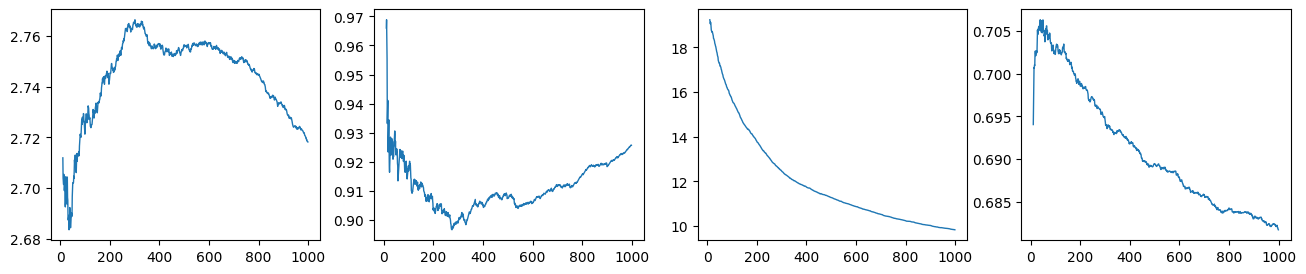

In [ ]:
print(len(losses))
plt.figure(figsize=(16, 3))
for i, s in enumerate([losses, accuracies, losses_mlm, losses_ce]):
    plt.subplot(1, 4, i+1)
    pd.Series(s).ewm(1000).mean()[10:].plot(lw=1);

In [ ]:
plot_for_report(losses, r"Значение функции ошибки $\mathcal{J}_{align}(\phi)$")

# plt.savefig('drive/MyDrive/diploma/loasses2_2k+1k+1k.pdf')
# plt.show()

In [ ]:
plot_for_report(accuracies, r"Точность")

# plt.savefig('drive/MyDrive/diploma/accuracies2_2k+1k+1k.pdf')
# plt.show()

In [ ]:
plot_for_report(losses_mlm, r"Значение функции ошибки $\mathcal{J}_{MLM}(\phi)$")

# plt.savefig('drive/MyDrive/diploma/losses2_MLM_2k+1k+1k.pdf')
# plt.show()

# Validate model on dev

In [ ]:
import torch


def validate_model(
        model,
        tokenizer,
        data,
        batch_size,
    ):
    loss_fn = torch.nn.CrossEntropyLoss()

    losses = []
    for i in range(0, len(data), batch_size):
        current_data = data[i:i+batch_size]
        mdf = [sample[0] for sample in current_data]
        ru = [sample[1] for sample in current_data]

        with torch.inference_mode():
            batch = tokenizer(ru+mdf, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
            embeddings = torch.nn.functional.normalize(model.bert(**batch, output_hidden_states=True).pooler_output)

        all_scores = torch.matmul(embeddings[:batch_size], embeddings[batch_size:].T)

        loss = loss_fn(
            all_scores, torch.arange(batch_size, device=model.device)
        ) + loss_fn(
            all_scores.T, torch.arange(batch_size, device=model.device)
        )

        losses.append(loss.item())

    return losses


In [ ]:
with open(DATA_PATH_PREFIX + 'dev.json', 'r') as f:
    dev_pairs = json.load(f)
print({source: len(pairs) for (source, pairs) in dev_pairs.items()})

{'bible': 400, 'mother_gorkiy': 100, 'chapaev': 200, 'distant_countries_gaydar': 100}


In [ ]:
MODEL_DIR = 'drive/MyDrive/diploma/labse_moksha_40k+1k'

model = AutoModelForPreTraining.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

In [ ]:
losses = {source: validate_model(model, tokenizer, pairs, 10) for (source, pairs) in dev_pairs.items()}

In [ ]:
{source: sum(loss) / len(loss) for (source, loss) in losses.items()}

{'bible': 3.9088838934898376,
 'mother_gorkiy': 3.616985297203064,
 'chapaev': 3.510742890834808,
 'distant_countries_gaydar': 3.556806135177612}

In [ ]:
import itertools


all_losses = list(itertools.chain(*list(losses.values())))

In [ ]:
sum(all_losses) / len(all_losses)

3.7288515985012056

In [ ]:
stat = {}

for i in range(1, 6):
    MODEL_DIR = f'drive/MyDrive/diploma/labse_moksha_40k+{i}k'
    print(MODEL_DIR.split('/')[-1])

    model = AutoModelForPreTraining.from_pretrained(MODEL_DIR)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

    losses = {source: validate_model(model, tokenizer, pairs, 10) for (source, pairs) in dev_pairs.items()}

    stat[i] = {source: sum(loss) / len(loss) for (source, loss) in losses.items()}

    print(stat[i])
    print()

{'bible': 3.9088838934898376, 'mother_gorkiy': 3.616985297203064, 'chapaev': 3.510742890834808, 'distant_countries_gaydar': 3.556806135177612}
{'bible': 3.857782781124115, 'mother_gorkiy': 3.5811471939086914, 'chapaev': 3.4298375487327575, 'distant_countries_gaydar': 3.4848047733306884}
{'bible': 3.8802395820617677, 'mother_gorkiy': 3.5616167068481444, 'chapaev': 3.417472004890442, 'distant_countries_gaydar': 3.458827543258667}
{'bible': 3.8671474397182464, 'mother_gorkiy': 3.553277850151062, 'chapaev': 3.4066776037216187, 'distant_countries_gaydar': 3.4450372219085694}
{'bible': 3.8625361919403076, 'mother_gorkiy': 3.543059206008911, 'chapaev': 3.3845982789993285, 'distant_countries_gaydar': 3.422333240509033}
